In [1]:
from modeling_bart_origin import BartForConditionalGeneration
import torch
from transformers import AutoModel,AutoTokenizer,PegasusForConditionalGeneration
from transformers import BartTokenizerFast,PegasusTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

model = PegasusForConditionalGeneration.from_pretrained("/mnt/nas4/m11115088/WordRank/XSUM_Models/GPT_pegasus", output_attentions=True)
# x = torch.load("cache/06-21-23-32-1718983941_BART_SSAN_0/model_cur4.bin", map_location='cpu')
x = torch.load("cache/06-25-13-41-1719294111_pegasus_LLM_XSUM_NN_VB_JJ_RB_CD/model_cur1.bin", map_location='cpu')
new_x = {}
for key, value in x.items():
    if "final_logits_bias" in key or "lm_head.weight" in key:
        new_x[key.replace('model.', '')] =  value 
    else:
        new_x[key.replace('model.model.', 'model.')] =  value 
model.load_state_dict(new_x)
model.eval()
# model = model.to(f"cuda:0")


# Load tokenizer and model
tokenizer = PegasusTokenizer.from_pretrained('/mnt/nas4/m11115088/WordRank/XSUM_Models/GPT_pegasus')


In [2]:
from datasets import load_from_disk
data = load_from_disk("/mnt/nas4/m11115088/WordRank/Dataset/cnndm_gpt_all")['train']
from nltk import sent_tokenize,word_tokenize
from nltk.corpus import stopwords
import string
import nltk
# text = sent_tokenize(data[0]['document'])[0]
text = data[1]['document']
summary = data[1]['summary']

In [34]:
keyword=[]
src_txt_list = word_tokenize(text)
src_txt_list_lower = word_tokenize(text.lower())
# candidate_ids=[]
for abs_stn in sent_tokenize(summary):
    nomal_abstract=word_tokenize(abs_stn)
    for i,(word,tag) in enumerate(nltk.pos_tag(nomal_abstract)):
        # if tag not in ["CC","CD","DT","MD","IN","VBZ","TO","WRB","WP$","WDT","WP",":"]:
        # if "NN" in tag or "VB" in tag or "JJ" in tag or "RB" in tag or "CD" in tag or "RP" in tag:
        if "NN" in tag or "VB" in tag or "JJ" in tag or "RB" in tag or "CD" in tag:
        # if "NN" in tag or "VB" in tag or "JJ" in tag or "RB" in tag:
        # if "NN" in tag or "VB" in tag or "JJ" in tag:
        # if "NN" in tag or "VB" in tag:
            word=word.strip(string.punctuation)
            if word not in keyword and (word.lower() not in stopwords.words('english')+list(string.punctuation)):
                if word in src_txt_list:
                    keyword.append(word)
                if word.lower() in src_txt_list:
                    keyword.append(word.lower())
                if word.lower() in src_txt_list_lower:
                    w_idx = src_txt_list_lower.index(word.lower())
                    keyword.append(src_txt_list[w_idx])
keyword = list(set(keyword))
print(keyword)

['2008', 'state', 'Soledad', 'pretrial', 'not', 'CNN', 'change', 'working', 'floor', 'forgotten', 'judge', 'ill', 'new', 'never', 'inmates', 'mentally', 'county', 'Starting', 'treatment', 'mental', 'punishment', 'Steven', 'health', "O'Brien", 'Miami', 'this', 'jails', 'Judge', 'Leifman', 'people']


In [3]:

# Encode some text
encoder_input = tokenizer(text, return_tensors='pt', add_special_tokens=True)
decoder_input = tokenizer(summary, return_tensors='pt', add_special_tokens=True)
outputs = model(
    input_ids=encoder_input['input_ids'].to(f"cuda:0"),
    attention_mask=encoder_input['attention_mask'].to(f"cuda:0"),
    labels=decoder_input['input_ids'].to(f"cuda:0"),
)

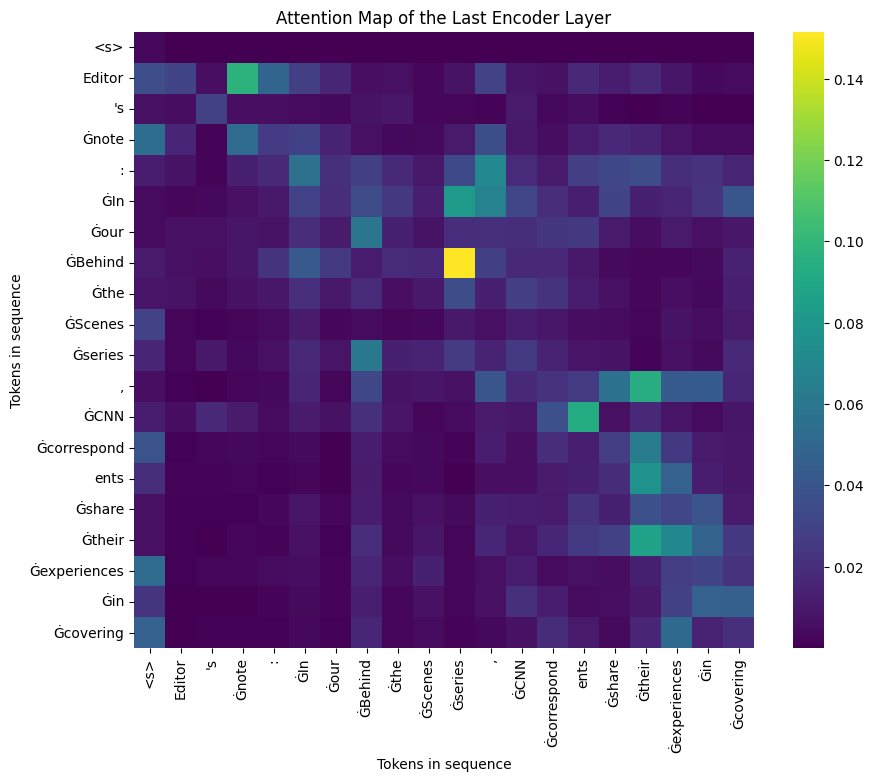

: 

In [4]:

# `attention` is a tuple containing the attention weights from each layer
attentions = outputs.encoder_attentions

# Get the attention map from the last layer
# Assume using the first and only example, and focusing on the first attention head
s=0
e=20
last_layer_attention = attentions[-1][0, 1, s:e,s:e].detach()

# Get the tokens from the encoded input
tokens = tokenizer.convert_ids_to_tokens(encoder_input['input_ids'][0][s:e])

# Plot the attention map
plt.figure(figsize=(10, 8))
sns.heatmap(last_layer_attention.cpu(), xticklabels=tokens, yticklabels=tokens, cmap='viridis')
plt.title("Attention Map of the Last Encoder Layer")
plt.xlabel("Tokens in sequence")
plt.ylabel("Tokens in sequence")
plt.show()


In [2]:
import torch
from torch.distributions import RelaxedBernoulli

# 溫度參數
temperature = 0.5
# 概率參數
probs = torch.tensor([[0.2, 0.8],[0.2, 0.8]])

# 創建一個 RelaxedBernoulli 分布
relaxed_bernoulli = RelaxedBernoulli(temperature, probs)

# 從分布中抽取樣本
sample = relaxed_bernoulli.sample()
print(sample)


tensor([[0.3434, 0.0058],
        [0.5658, 0.6845]])


Text(0, 0.5, 'token')

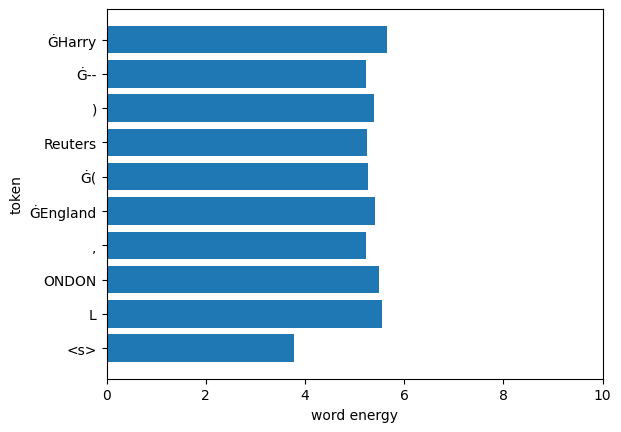

In [39]:
fig, ax = plt.subplots()
# colors = ['cornflowerblue' if label not in keyword else 'red' for label in seg_word_n[::-1]]
ax.set_xlim(0, 10)
tokens = tokenizer.convert_ids_to_tokens(encoder_input['input_ids'][0])
# ax.barh(seg_word_n[::-1], s_w_y[::-1], color=colors)
ax.barh(tokens[:10], outputs.word_energy[0].cpu().detach().numpy()[:10])

# 設定圖表標題和軸標籤
# plt.title('第'+dic_num[str(i+1)]+'句', fontproperties=font)
# plt.title('最後一句', fontproperties=font)
plt.xlabel('word energy')
plt.ylabel('token')